# Count data simulation
This notebook simulate k-seq count dataset from 1) independent parametric distributions; 2) fitted results, for method evaluation

In [166]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode('k-seq')
dev_mode.on()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from k_seq.data import simu
reload(simu)
plt.style.use('seaborn')

In [167]:
# Fix the substrates concentrations across all simulation
c_list = [-1, 2e-6, 10e-6, 50e-6, 250e-5, 1250e-6]

# Quick view of actual dataset

In [122]:
fit_res = pd.read_csv('/mnt/storage/projects/k-seq/working/byo_doped/least_square/point-est_bounded_pod_10-21-19/fit_summary.csv')

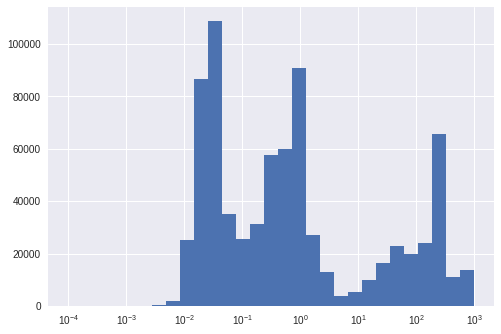

In [131]:
bins = np.logspace(-4, 3, 30)
plt.hist(fit_res['k'], bins=bins)
plt.xscale('log')

# Simulate from individual distribution

In [195]:
def simulate_from_distribution(seq_num, depth, p0_loc, p0_scale, k_95, save_to):
    from k_seq.data.simu import DistGenerators, pool_counts_simulator
    
    N_list = [seq_num * depth for _ in c_list]
    
    x, Y, truth = pool_counts_simulator(
        pool_size=seq_num,
        c_list=c_list,
        N_list=N_list,
        p0=DistGenerators.compo_lognormal(loc=p0_loc, scale=p0_scale, size=seq_num),
        k=DistGenerators.lognormal(c95=k_95, size=seq_num),
        A=DistGenerators.uniform(lowi=0, high=1, size=seq_num),
        reps=3,
        save_to=save_to,
        seed=23
    )
    
    with open(save_to + '/config.txt', 'w') as handle:
        handle.write(
            f'seq_num: {seq_num}\ndepth: {depth}\n'
            f'p0: loc:{p0_loc} scale: {p0_scale}\nk_95: {k_95}'
        )
 
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 3))
    init_pools = Y.loc[:, x.loc['c'] < 0]
    p0 = (init_pools/ init_pools.sum(axis=0)).sum(axis=1)
    axes[0].hist(p0, bins=20)
    axes[0].set_xlabel('p0, init count avg', fontsize=14)
    axes[1].hist(truth.A, bins=20)
    axes[1].set_xlabel('a', fontsize=14)
    bins = np.logspace(np.log10(truth.k.min()) - 0.5, np.log10(truth.k.max()) + 0.5, 20)
    axes[2].hist(truth.k, bins=bins)
    axes[2].set_xscale('log')
    axes[2].set_xlabel('k', fontsize=14)
    ka = truth.k * truth.A
    bins = np.logspace(np.log10(ka.min()) - 0.5, np.log10(ka.max()) + 0.5, 20)
    axes[3].hist(ka, bins=bins)
    axes[3].set_xscale('log')
    axes[3].set_xlabel('k * a', fontsize=14)
    plt.show()
    
    return x, Y, truth

## Small, even pool, low depth 

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


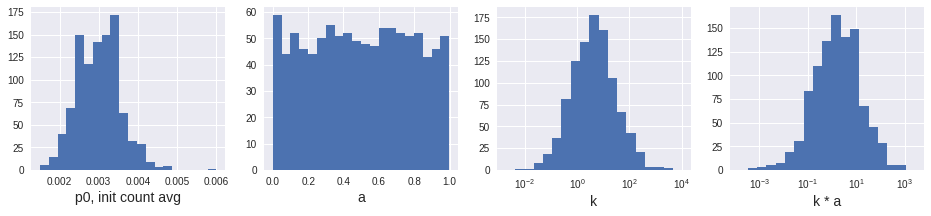

In [196]:
x, Y, truth = simulate_from_distribution(seq_num=1_000,
                                         depth=10,
                                         p0_loc=0,
                                         p0_scale=0,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_shallow')

## Small, even pool, high depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


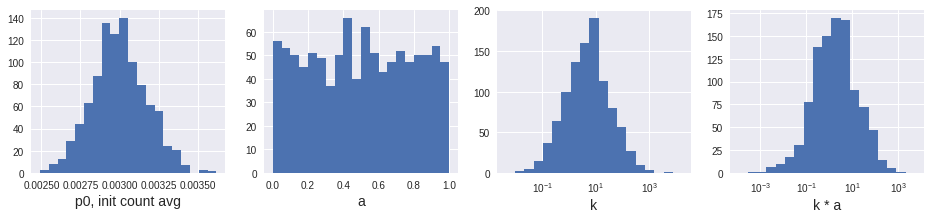

In [197]:
x, Y, truth = simulate_from_distribution(seq_num=1_000,
                                         depth=100,
                                         p0_loc=0,
                                         p0_scale=0,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_even_deep')

## Small, uneven pool, low depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


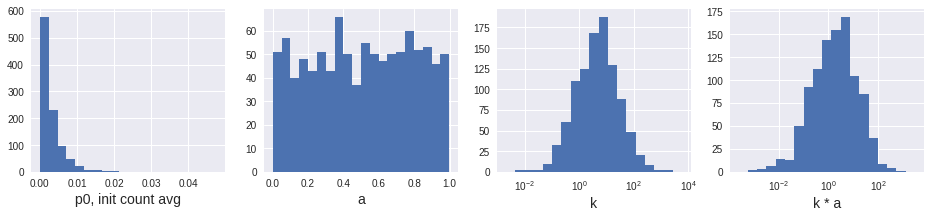

In [198]:
x, Y, truth = simulate_from_distribution(seq_num=1_000,
                                         depth=10,
                                         p0_loc=0,
                                         p0_scale=1,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_uneven_shallow')

## Small, uneven pool, high depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


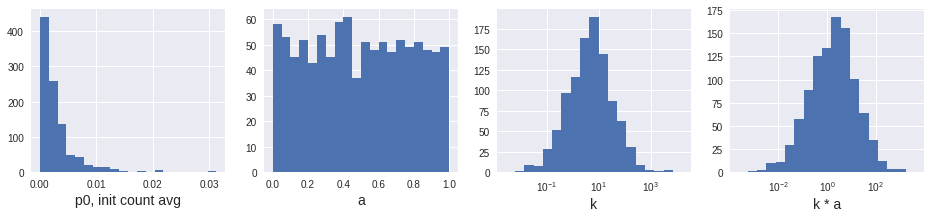

In [199]:
x, Y, truth = simulate_from_distribution(seq_num=1_000,
                                         depth=100,
                                         p0_loc=0,
                                         p0_scale=1,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_small_uneven_deep')

## Large, even pool, low depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


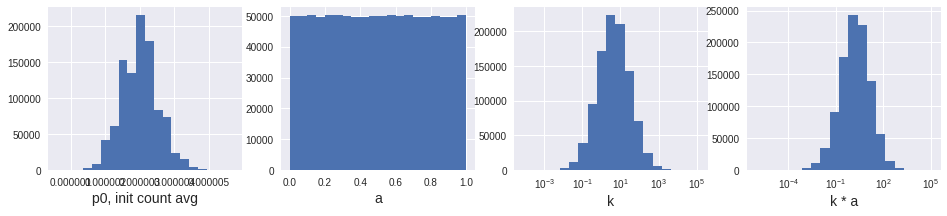

In [200]:
x, Y, truth = simulate_from_distribution(seq_num=1_000_000,
                                         depth=10,
                                         p0_loc=0,
                                         p0_scale=0,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_large_even_shallow')

## Large, even pool, high depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


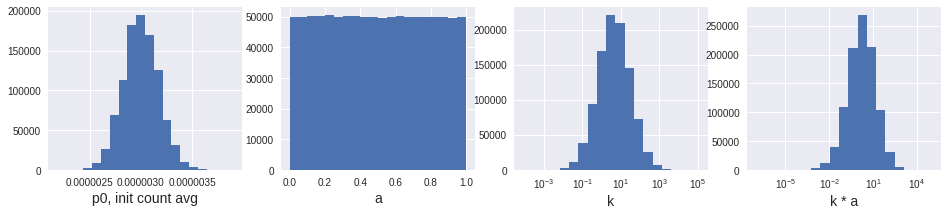

In [201]:
x, Y, truth = simulate_from_distribution(seq_num=1_000_000,
                                         depth=100,
                                         p0_loc=0,
                                         p0_scale=0,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_large_even_deep')

## Large, uneven, low depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


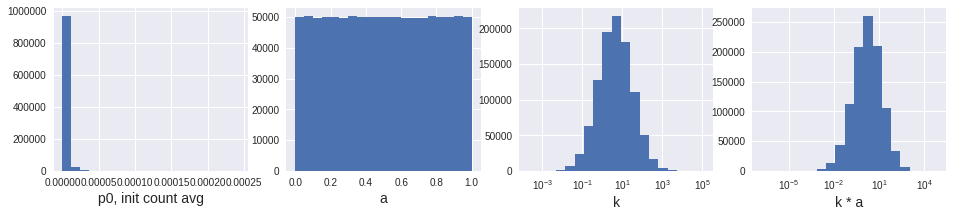

In [202]:
x, Y, truth = simulate_from_distribution(seq_num=1_000_000,
                                         depth=10,
                                         p0_loc=0,
                                         p0_scale=1,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_large_uneven_shallow')

## Large, uneven, high depth

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


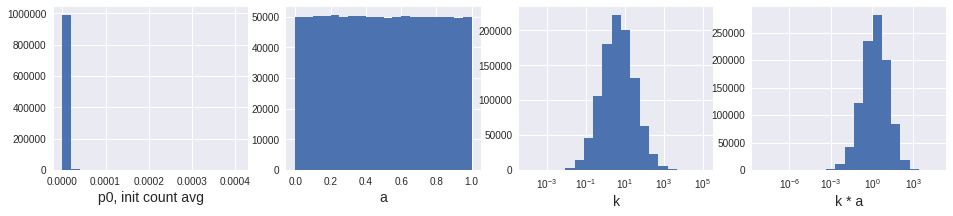

In [203]:
x, Y, truth = simulate_from_distribution(seq_num=1_000_000,
                                         depth=100,
                                         p0_loc=0,
                                         p0_scale=1,
                                         k_95=[0.1, 200],
                                         save_to='/mnt/storage/projects/k-seq/datasets/simulated/dist_large_uneven_deep')

# Simulate from data

We simulate pool from estimated data to mimic the actual distribution

We use `least-squared` point-estimation for `doped-pool` as template for sampling 

- We filtered the sequence by the sequences we can perform classic least squared fitting (that only contains sequences observed in the input pool

In [238]:
def pairplot(data, vars_name=None, vars_lim=None, vars_log=None, figsize=(2, 2), **kwargs):
    import numpy as np
    if vars_name is None:
        vars_name = list(data.columns)
    else:
        data = data[vars_name]
    
    for var, var_log in zip(vars_name, vars_log):
        if var_log:
            data.loc[:, var] = data[var].apply(np.log10)
            data.rename(columns={var: "$\log_{10}$(%s)" %(var)}, inplace=True)

    return sns.pairplot(data=data, vars=data.columns,
                        markers='o', plot_kws=dict(s=5, edgecolor=None, alpha=0.3),
                        height=figsize[1], aspect=figsize[0]/figsize[1], **kwargs)

def simulate_from_sample(seq_num, depth, save_to):
    reload(simu)
    from k_seq.data.simu import pool_counts_simulator
    
    N_list = [seq_num * depth for _ in c_list]
    
    x, Y, truth = pool_counts_simulator(
        pool_size=seq_num,
        c_list=c_list,
        N_list=[depth * seq_num for _ in c_list],
        sample_from_table=ls_point_est,
        weights=None,
        replace=True,
        reps=3,
        save_to=save_to,
        seed=23
    )
    
    with open(save_to + '/config.txt', 'w') as handle:
        handle.write(f'seq_num: {seq_num}\ndepth: {depth}\n')
 
    init_pools = Y.loc[:, x.loc['c'] < 0]
    truth['p0_from_counts'] = (init_pools/ init_pools.sum(axis=0)).sum(axis=1)
    truth['ka'] = truth.k * truth.A
    pairplot(data=truth, vars_name=['p0', 'A', 'k', 'ka'],
             vars_log=[True, False, True, True], diag_kind='kde')
    
    plt.show()
    return x, Y, truth


In [231]:
from k_seq.data.seq_table import SeqTable
import pandas as pd

byo_doped = SeqTable.load_default_dataset(dataset='byo-doped')
ls_point_est = pd.read_csv('/mnt/storage/projects/k-seq/working/byo_doped/least_square/point-est_bounded_pod_10-21-19/fit_summary.csv', index_col=0)

# survey initial pool composition from byo_doped and add to ls_point_est
counts = byo_doped.table['R0'][ls_point_est.index]
counts = counts.sparse.to_dense()
ls_point_est['counts'] = counts
ls_point_est['p0'] = counts / np.sum(counts)
ls_point_est = ls_point_est[~ls_point_est.isna().any(axis=1)]
print(ls_point_est.describe())
ls_point_est = ls_point_est[['k', 'A', 'p0']]

Load BYO-doped pool data from pickled record from /mnt/storage/projects/k-seq/datasets/byo_doped.pkl
Imported!
                   k              A        counts            p0
count  841394.000000  841394.000000  8.413940e+05  8.413940e+05
mean      293.717752       0.361150  3.877338e+01  1.188401e-06
std      2047.994716       0.451366  2.959908e+03  9.072095e-05
min         0.000537       0.000424  1.000000e+00  3.064993e-08
25%         0.040065       0.018894  1.000000e+00  3.064993e-08
50%         0.570741       0.046121  2.000000e+00  6.129985e-08
75%        78.834191       0.994883  4.000000e+00  1.225997e-07
max    207140.276152       1.000000  1.452168e+06  4.450884e-02


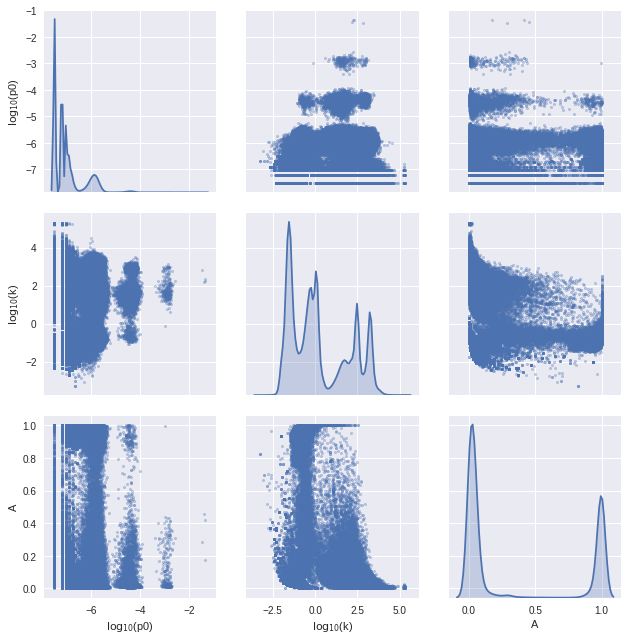

In [232]:
pp = pairplot(ls_point_est, vars_name=['p0', 'k', 'A'], vars_log=[True, True, False], diag_kind='kde')

In [240]:
default_depth = 40

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


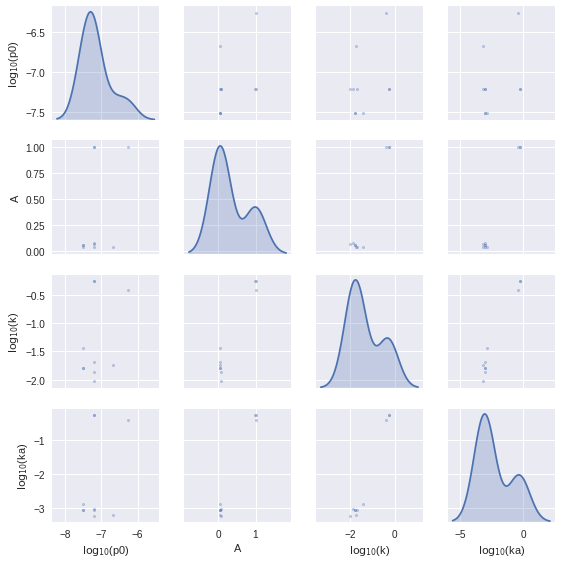

In [239]:
x, Y, truth = simulate_from_sample(
    seq_num=10,
    depth=default_depth,
    save_to=f'/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s{seq_num}_d{depth}'
)

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/yuning/.pyenv/versions/k-seq/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


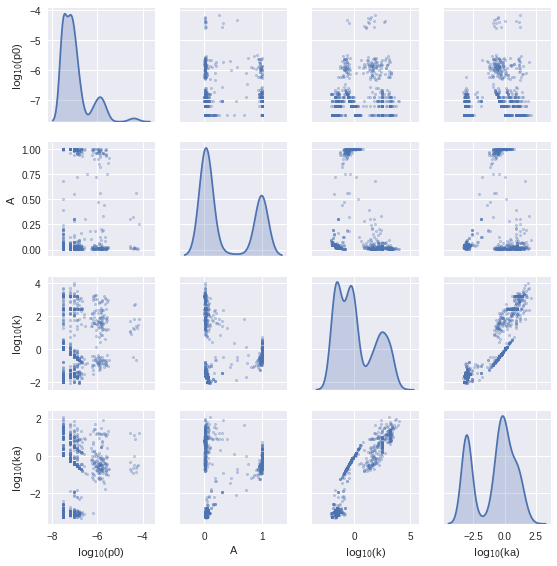

In [241]:
x, Y, truth = simulate_from_sample(
    seq_num=1000,
    depth=default_depth,
    save_to=f'/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s{seq_num}_d{depth}'
)

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


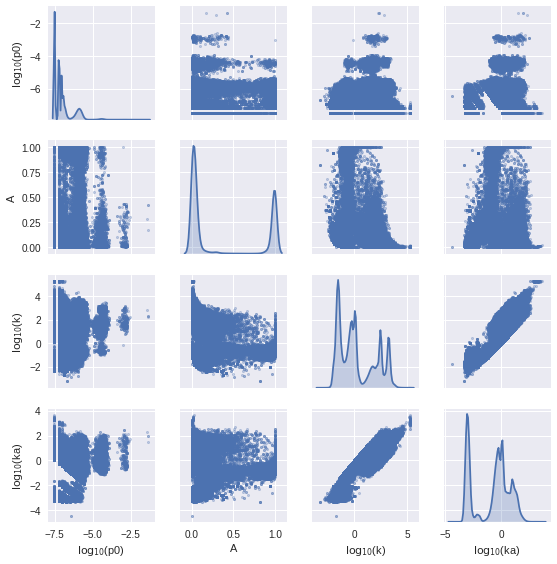

In [242]:
x, Y, truth = simulate_from_sample(
    seq_num=1_000_000,
    depth=default_depth,
    save_to=f'/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s{seq_num}_d{depth}'
)

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


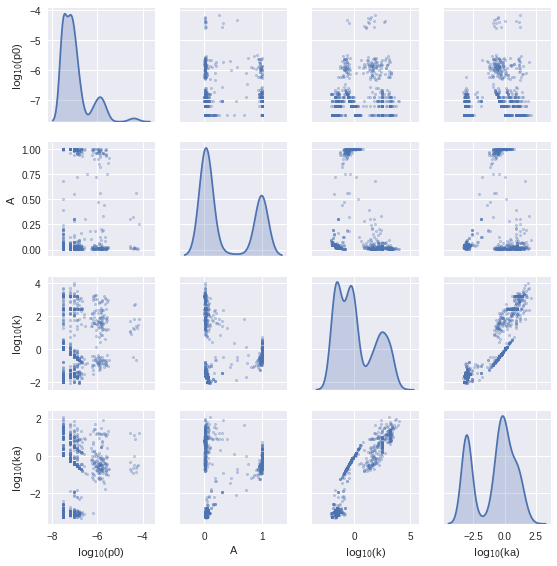

In [243]:
x, Y, truth = simulate_from_sample(
    seq_num=1_000,
    depth=10,
    save_to=f'/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s{seq_num}_d{depth}'
)

No kinetic model provided, use BYOModel.composition_first_order
No count model provided, use MultiNomial


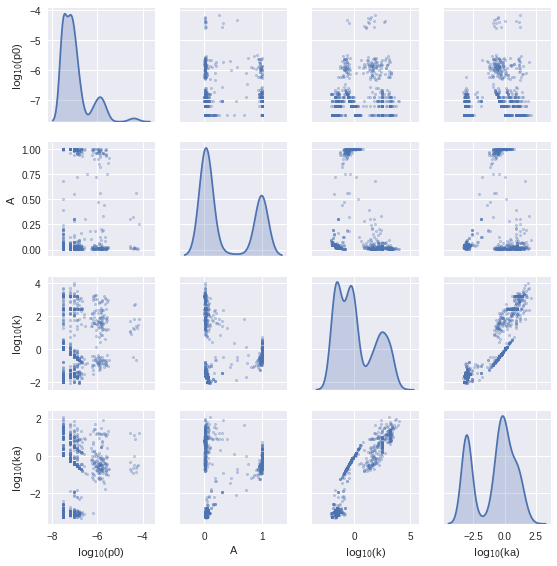

In [244]:
x, Y, truth = simulate_from_sample(
    seq_num=1_000,
    depth=100,
    save_to=f'/mnt/storage/projects/k-seq/datasets/simulated/on_doped_s{seq_num}_d{depth}'
)

## [Analysis] Caveats of sampling from a heterogenous pool

If not weighting each unique sequences, it will be more likely to sample the low pct seqs.

QUESTION: what does the heterogeneity means here? Entropy?

In [212]:
simu_pool_sizes = [-1, 1e1, 1e3, 1e5, 1e6, 1e7, 1e8]
from k_seq.data.simu import PoolParamSimulator

sampled_pool = [ls_point_est if size < 0 else PoolParamSimulator.sample_from_dataframe(df=ls_point_est, size=int(size),
                                                                                       seed=23)
                for size in simu_pool_sizes]

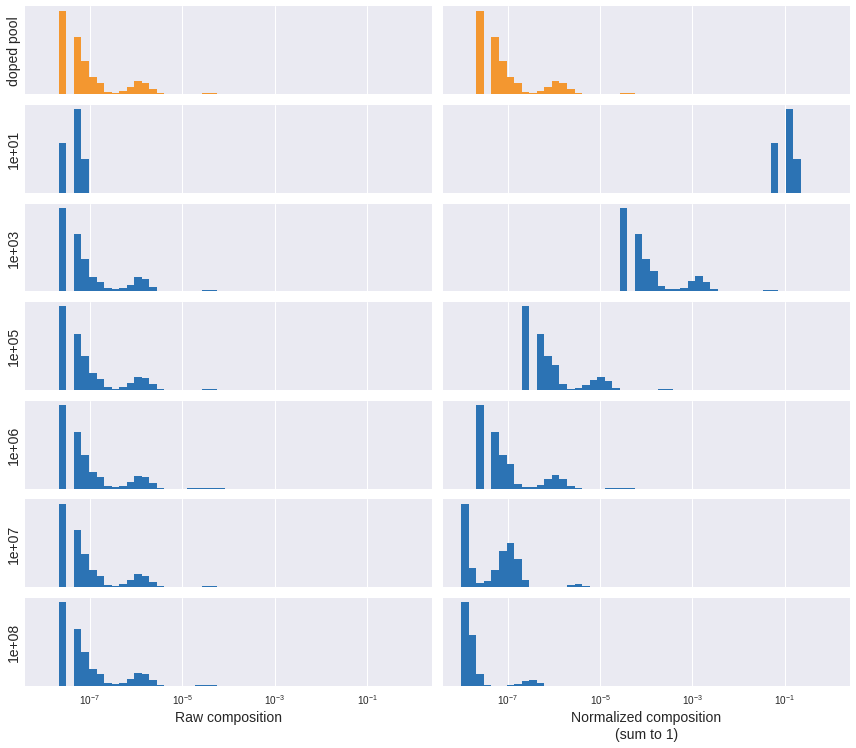

In [213]:
fig, axes = plt.subplots(len(simu_pool_sizes), 2,
                         figsize=[6 * 2, 1.5 * len(simu_pool_sizes)],
                         sharex=True)
fig.subplots_adjust(hspace=0.01, wspace=0.01)

bins = np.logspace(-8, 0, 50)
for ax, sample, size in zip(axes, sampled_pool, simu_pool_sizes):
    ax[0].hist(sample['p0'], bins=bins, color='#F39730' if size < 0 else '#2C73B4')
    ax[0].set_xscale('log')
    ax[0].set_yticks([])
    ax[0].set_ylabel('doped pool' if size <0 else f'{size:1.0e}', fontsize=14)
    ax[1].hist(sample['p0']/sample['p0'].sum(), bins=bins, color='#F39730' if size < 0 else '#2C73B4')
    ax[1].set_xscale('log')
    ax[1].set_yticks([])
axes[-1][0].set_xlabel('Raw composition', fontsize=14)
axes[-1][1].set_xlabel('Normalized composition\n(sum to 1)', fontsize=14)

plt.tight_layout()
plt.show()

In [214]:
def get_entropy(series, normalize=True, base=2):
    if pd.api.types.is_sparse(series):
        series = series.sparse.to_dense()
    series = series / np.sum(series)
    if normalize:
        return -np.sum(series * np.log(series)) / np.log(len(series))
    else:
        return -np.sum(series * np.log(series)) / np.log(base)

In [215]:
entropy_efficiency = [get_entropy(pool['p0'], normalize=True) for pool in sampled_pool]

In [216]:
entropy_efficiency

[0.6483428703023708,
 0.9696468912182086,
 0.6109410935818711,
 0.5089605113954405,
 0.6576124812379042,
 0.7006322329074502,
 0.7385569991223883]

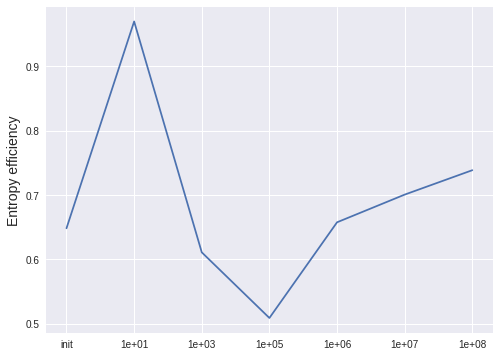

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(np.arange(len(simu_pool_sizes)), entropy_efficiency)
ax.set_xticks(np.arange(len(simu_pool_sizes)))
ax.set_xticklabels(['init' if size < 0 else f'{size:1.0e}' for size in simu_pool_sizes])
ax.set_ylabel('Entropy efficiency', fontsize=14)
plt.show()